# SETUP

In [1]:
from google.colab import files
uploaded = files.upload()

Saving simple_nli_mcq.csv to simple_nli_mcq.csv


In [2]:
!pip install datasets

!pip install transformers==4.42.4

!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 63.4 MB/s eta 0:00:00
   ━━

In [3]:
import os
import random

import torch
import openai

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import accuracy_score

# PROCESS DATA

## Load the dataset

In [6]:
dataset_name = "simple_nli_mcq"
nli_df = pd.read_csv(f"{dataset_name}.csv")

In [7]:
nli_df.head()

,Premise,Hypothesis,Question,Option A,Option B,Option C,Answer,Source
0,I don't know exactly when.,i don't know when.,Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,A,MNLI
1,Women weaving baskets with a child in between ...,Women sewing clothes while a baby sleeps.,Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,C,SNLI
2,uh-huh um-hum um-hum yeah that's because my th...,We usually just get ice cream so my girlfriend.,Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,C,MNLI
3,but i right but i agree it has to be at their ...,"People have different situations in life, so i...",Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,A,MNLI
4,When Mr. Hastings and Mr. Lawrence came in yes...,"Your mistress wrote letters last night, can yo...",Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,B,MNLI


## Label the expected cosine similarity

In [12]:
# Add the new feature 'Expected Cosine Similarity' based on the 'Answer' column
def determine_cosine_similarity(answer):
    if answer == 'A':  # Entailment
        return "Unpredictable"
    elif answer == 'B':  # Neutral
        return "Medium"
    elif answer == 'C':  # Contradiction
        return "Low"

In [13]:
# Apply the function to create the new column
nli_df['Expected Cosine Similarity'] = nli_df['Answer'].apply(determine_cosine_similarity)

In [14]:
nli_df.head()

,Premise,Hypothesis,Question,Option A,Option B,Option C,Answer,Source,Expected Cosine Similarity
0,I don't know exactly when.,i don't know when.,Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,A,MNLI,Unpredictable
1,Women weaving baskets with a child in between ...,Women sewing clothes while a baby sleeps.,Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,C,SNLI,Low
2,uh-huh um-hum um-hum yeah that's because my th...,We usually just get ice cream so my girlfriend.,Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,C,MNLI,Low
3,but i right but i agree it has to be at their ...,"People have different situations in life, so i...",Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,A,MNLI,Unpredictable
4,When Mr. Hastings and Mr. Lawrence came in yes...,"Your mistress wrote letters last night, can yo...",Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,B,MNLI,Medium


In [15]:
nli_df.to_csv(f"{dataset_name}_labelled.csv", index=False)

In [16]:
files.download(f"{dataset_name}_labelled.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Embedding

### Setup Embedding

In [ ]:
# Load the NV-Embed-v2 model and tokenizer
model = AutoModel.from_pretrained("nvidia/NV-Embed-v2", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("nvidia/NV-Embed-v2", trust_remote_code=True)

In [17]:
# Method to generate embeddings
def get_embeddings(texts, batch_size=8, max_length=512):
    return model._do_encode(texts, batch_size=batch_size, max_length=max_length, num_workers=0, return_numpy=True)

### Embed Premises and Hypotheses

In [18]:
# Generate embeddings for Premise
premise_embeddings_name = f"premise_embeddings_for_dataset_{dataset_name}.csv"
# premise_embeddings = get_embeddings(nli_df['Premise'].tolist())
# premise_embeddings_df = pd.DataFrame(premise_embeddings)
# premise_embeddings_df.to_csv(premise_embeddings_name, index=False)

# Generate embeddings for Hypothesisc
hypothesis_embeddings_name = f"hypothesis_embeddings_for_dataset_{dataset_name}.csv"
# hypothesis_embeddings = get_embeddings(nli_df['Hypothesis'].tolist())
# hypothesis_embeddings_df = pd.DataFrame(hypothesis_embeddings)
# hypothesis_embeddings_df.to_csv(hypothesis_embeddings_name, index=False)

### Load the embedding results

In [ ]:
uploaded_embeddings = files.upload()

In [19]:
premise_embeddings_df = pd.read_csv(premise_embeddings_name)
hypothesis_embeddings_df = pd.read_csv(hypothesis_embeddings_name)

In [20]:
premise_embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,-0.020892,0.016839,0.000331,0.003352,-0.012434,-0.018491,0.014293,0.015357,-0.017695,-0.004734,...,0.013639,0.001797,-0.010607,-0.005760,0.015742,-0.049329,-0.046134,-0.003213,-0.001324,-0.002122
1,-0.021711,-0.000284,0.002632,0.033610,-0.003357,-0.026663,-0.004828,-0.004135,0.015457,0.007796,...,-0.006478,0.015285,0.011420,-0.013303,0.013706,-0.045454,0.005249,0.005884,-0.003026,-0.002350
2,-0.011432,0.013519,0.011138,-0.000431,-0.003356,-0.024145,0.021229,-0.001147,-0.011116,0.011426,...,-0.008029,-0.003248,0.021401,-0.023195,-0.037904,-0.066127,0.007112,-0.010105,-0.011273,-0.002150
3,-0.031937,0.017538,0.007932,0.011127,-0.003398,0.013168,-0.003599,-0.009629,-0.025356,-0.013288,...,0.006218,0.019983,-0.014215,-0.024259,0.002646,0.029942,-0.022710,-0.001186,-0.005061,-0.014353
4,0.010272,0.002715,-0.002747,0.025306,-0.015044,-0.028360,0.009094,0.020080,0.019158,0.001963,...,0.011735,-0.011912,0.003297,0.007369,0.007836,-0.004732,0.014980,0.012852,-0.020928,-0.021752


In [21]:
hypothesis_embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,-0.022301,0.003723,-0.002421,0.011234,-0.009342,-0.017679,0.012597,0.008722,-0.022061,-0.008941,...,0.014415,-0.005230,-0.010663,-0.009286,0.018324,-0.056283,-0.039790,-0.004581,-0.013203,-0.000411
1,-0.007187,0.001789,0.018836,0.015885,-0.004295,0.001367,-0.015688,-0.018782,0.004248,-0.024412,...,-0.004220,0.022535,0.010502,0.010999,0.027524,-0.056616,0.023965,-0.017824,-0.009819,0.009247
2,-0.019431,-0.002287,0.022774,0.025964,0.012023,-0.001181,0.013038,0.000271,0.015212,-0.009835,...,0.014644,-0.000835,0.001331,-0.004930,-0.015084,-0.056150,0.012310,0.002957,-0.008389,-0.020561
3,-0.003127,0.005064,0.001528,-0.016062,-0.012353,-0.002051,0.013588,0.008027,-0.009022,-0.033964,...,0.026056,-0.006322,-0.009077,0.001054,-0.029328,0.038186,0.000271,-0.013819,0.005688,0.000148
4,-0.001229,-0.001307,0.025682,0.010567,0.008018,-0.025623,0.001856,0.007802,0.009662,0.002693,...,0.028043,-0.011377,0.007114,0.045481,0.013879,-0.031912,-0.000548,-0.005093,0.001723,-0.011860


## Drop the "Entailment" samples

In [23]:
# Filter the rows where the Answer column is not 'A' (entailment)
filtered_nli_df = nli_df[nli_df['Answer'] != 'A'].reset_index(drop=True)

# Identify the indices of rows with 'A' in the original dataset
entailment_indices = nli_df[nli_df['Answer'] == 'A'].index

# Drop the corresponding rows in the embeddings datasets
filtered_premise_embeddings_df = premise_embeddings_df.drop(entailment_indices).reset_index(drop=True)
filtered_hypothesis_embeddings_df = hypothesis_embeddings_df.drop(entailment_indices).reset_index(drop=True)

# Optional: Check the shapes of the filtered datasets to ensure alignment
print(f"Filtered NLI dataset shape: {filtered_nli_df.shape}")
print(f"Filtered Premise Embeddings shape: {filtered_premise_embeddings_df.shape}")
print(f"Filtered Hypothesis Embeddings shape: {filtered_hypothesis_embeddings_df.shape}")

# Now you have `filtered_dataset`, `filtered_premise_embeddings`, and `filtered_hypothesis_embeddings`
# without rows corresponding to "A" in the Answer column of the original dataset.

Filtered NLI dataset shape: (347, 9)
Filtered Premise Embeddings shape: (347, 4096)
Filtered Hypothesis Embeddings shape: (347, 4096)


In [24]:
filtered_nli_df.head()

,Premise,Hypothesis,Question,Option A,Option B,Option C,Answer,Source,Expected Cosine Similarity
0,Women weaving baskets with a child in between ...,Women sewing clothes while a baby sleeps.,Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,C,SNLI,Low
1,uh-huh um-hum um-hum yeah that's because my th...,We usually just get ice cream so my girlfriend.,Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,C,MNLI,Low
2,When Mr. Hastings and Mr. Lawrence came in yes...,"Your mistress wrote letters last night, can yo...",Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,B,MNLI,Medium
3,It was published in the Federal Register as a ...,It was later made available for online reading.,Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,B,MNLI,Medium
4,On the basis of our literature searches and di...,Commercial companies always outsource their pr...,Do the hypothesis and premise logically entail...,entailment,neutral,contradiction,C,MNLI,Low


In [26]:
filtered_nli_df.to_csv(f"filtered_{dataset_name}.csv", index=False)
filtered_premise_embeddings_df.to_csv(f"filtered_premise_embeddings_for_dataset_{dataset_name}.csv", index=False)
filtered_hypothesis_embeddings_df.to_csv(f"filtered_hypothesis_embeddings_for_dataset_{dataset_name}.csv", index=False)

In [27]:
files.download(f"filtered_{dataset_name}.csv")
files.download(f"filtered_premise_embeddings_for_dataset_{dataset_name}.csv")
files.download(f"filtered_hypothesis_embeddings_for_dataset_{dataset_name}.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Separate the "Neutral" and "Contradiction" samples

In [28]:
# Identify indices for "Neutral" and "Contradiction" in the filtered dataset
neutral_indices = filtered_nli_df[filtered_nli_df['Answer'] == 'B'].index
contradiction_indices = filtered_nli_df[filtered_nli_df['Answer'] == 'C'].index

In [31]:
# Separate embeddings into "Neutral" and "Contradiction"
neutral_premise_embeddings = filtered_premise_embeddings_df.iloc[neutral_indices]
neutral_hypothesis_embeddings = filtered_hypothesis_embeddings_df.iloc[neutral_indices]

contradiction_premise_embeddings = filtered_premise_embeddings_df.iloc[contradiction_indices]
contradiction_hypothesis_embeddings = filtered_hypothesis_embeddings_df.iloc[contradiction_indices]

In [32]:
neutral_premise_embeddings.to_csv(f"neutral_premise_embeddings_for_dataset_{dataset_name}.csv", index=False)
neutral_hypothesis_embeddings.to_csv(f"neutral_hypothesis_embeddings_for_dataset_{dataset_name}.csv", index=False)
contradiction_premise_embeddings.to_csv(f"contradiction_premise_embeddings_for_dataset_{dataset_name}.csv", index=False)
contradiction_hypothesis_embeddings.to_csv(f"contradiction_hypothesis_embeddings_for_dataset_{dataset_name}.csv", index=False)

In [33]:
files.download(f"neutral_premise_embeddings_for_dataset_{dataset_name}.csv")
files.download(f"neutral_hypothesis_embeddings_for_dataset_{dataset_name}.csv")
files.download(f"contradiction_premise_embeddings_for_dataset_{dataset_name}.csv")
files.download(f"contradiction_hypothesis_embeddings_for_dataset_{dataset_name}.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# EXPERIMENT

## Compute Cosine Similarity

In [36]:
# Ensure cosine similarities are computed correctly
neutral_cosine_similarities = [
    float(cosine_similarity(premise.values.reshape(1, -1), hypothesis.values.reshape(1, -1))[0][0])
    for _, premise in neutral_premise_embeddings.iterrows()
    for _, hypothesis in neutral_hypothesis_embeddings.iterrows()
]

contradiction_cosine_similarities = [
    float(cosine_similarity(premise.values.reshape(1, -1), hypothesis.values.reshape(1, -1))[0][0])
    for _, premise in contradiction_premise_embeddings.iterrows()
    for _, hypothesis in contradiction_hypothesis_embeddings.iterrows()
]

In [38]:
# Debugging: Print a sample of cosine similarities to ensure correctness
print("Sample Neutral Cosine Similarities:", neutral_cosine_similarities[:5])
print("Sample Contradiction Cosine Similarities:", contradiction_cosine_similarities[:5])

Sample Neutral Cosine Similarities: [0.568970209707192, 0.09231659196758854, 0.0894492359951474, 0.08203525618934346, 0.07162720346056067]
Sample Contradiction Cosine Similarities: [0.3422938868120929, 0.05220002879384956, 0.015176134721860485, -0.008348922059113317, -0.03139258910953996]


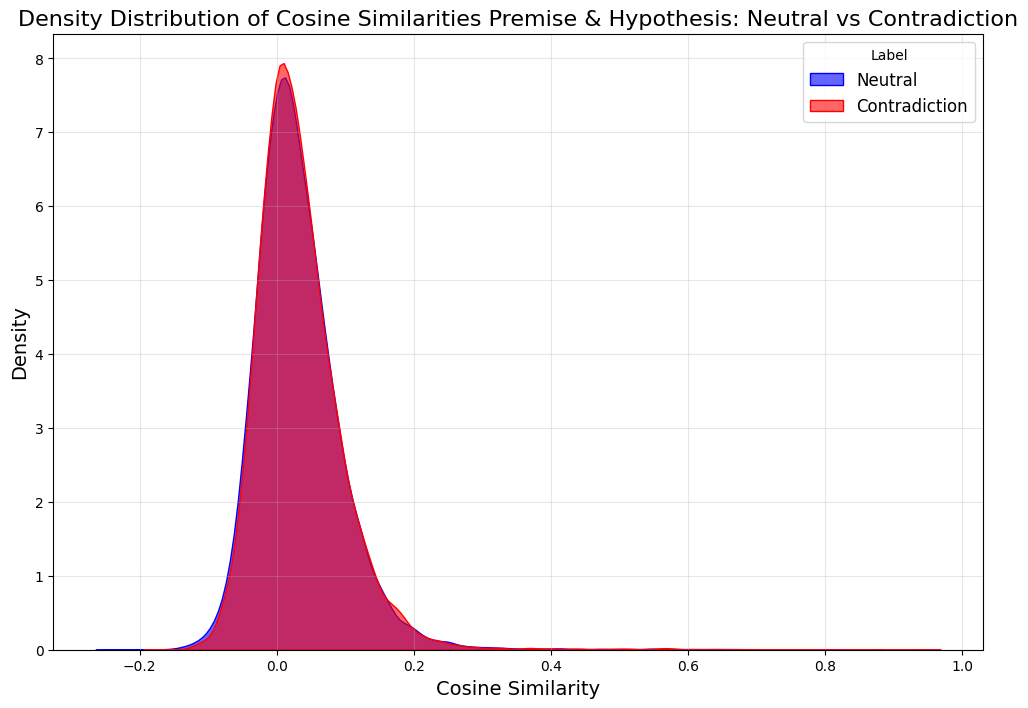

In [37]:
# Plot density distributions
plt.figure(figsize=(12, 8))
sns.kdeplot(neutral_cosine_similarities, fill=True, color="blue", alpha=0.6, label="Neutral")
sns.kdeplot(contradiction_cosine_similarities, fill=True, color="red", alpha=0.6, label="Contradiction")

# Add titles and labels
plt.title("Density Distribution of Cosine Similarities Premise & Hypothesis: Neutral vs Contradiction", fontsize=16)
plt.xlabel("Cosine Similarity", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=12, title="Label")
plt.grid(alpha=0.3)
plt.show()